In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from utils import *

In [22]:
train_X, train_Y, test_X, test_Y = load_multiple_files(2, Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), 300, 50)
train_dataset =  TimeSeriesDataset(train_X, train_Y)
test_dataset = TimeSeriesDataset(test_X, test_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([1, 50, 4]) torch.Size([1, 50, 4])
torch.Size([1, 50, 4]) torch.Size([1, 50, 4])
torch.Size([1, 50, 4]) torch.Size([1, 50, 4])
torch.Size([1, 50, 4]) torch.Size([1, 50, 4])


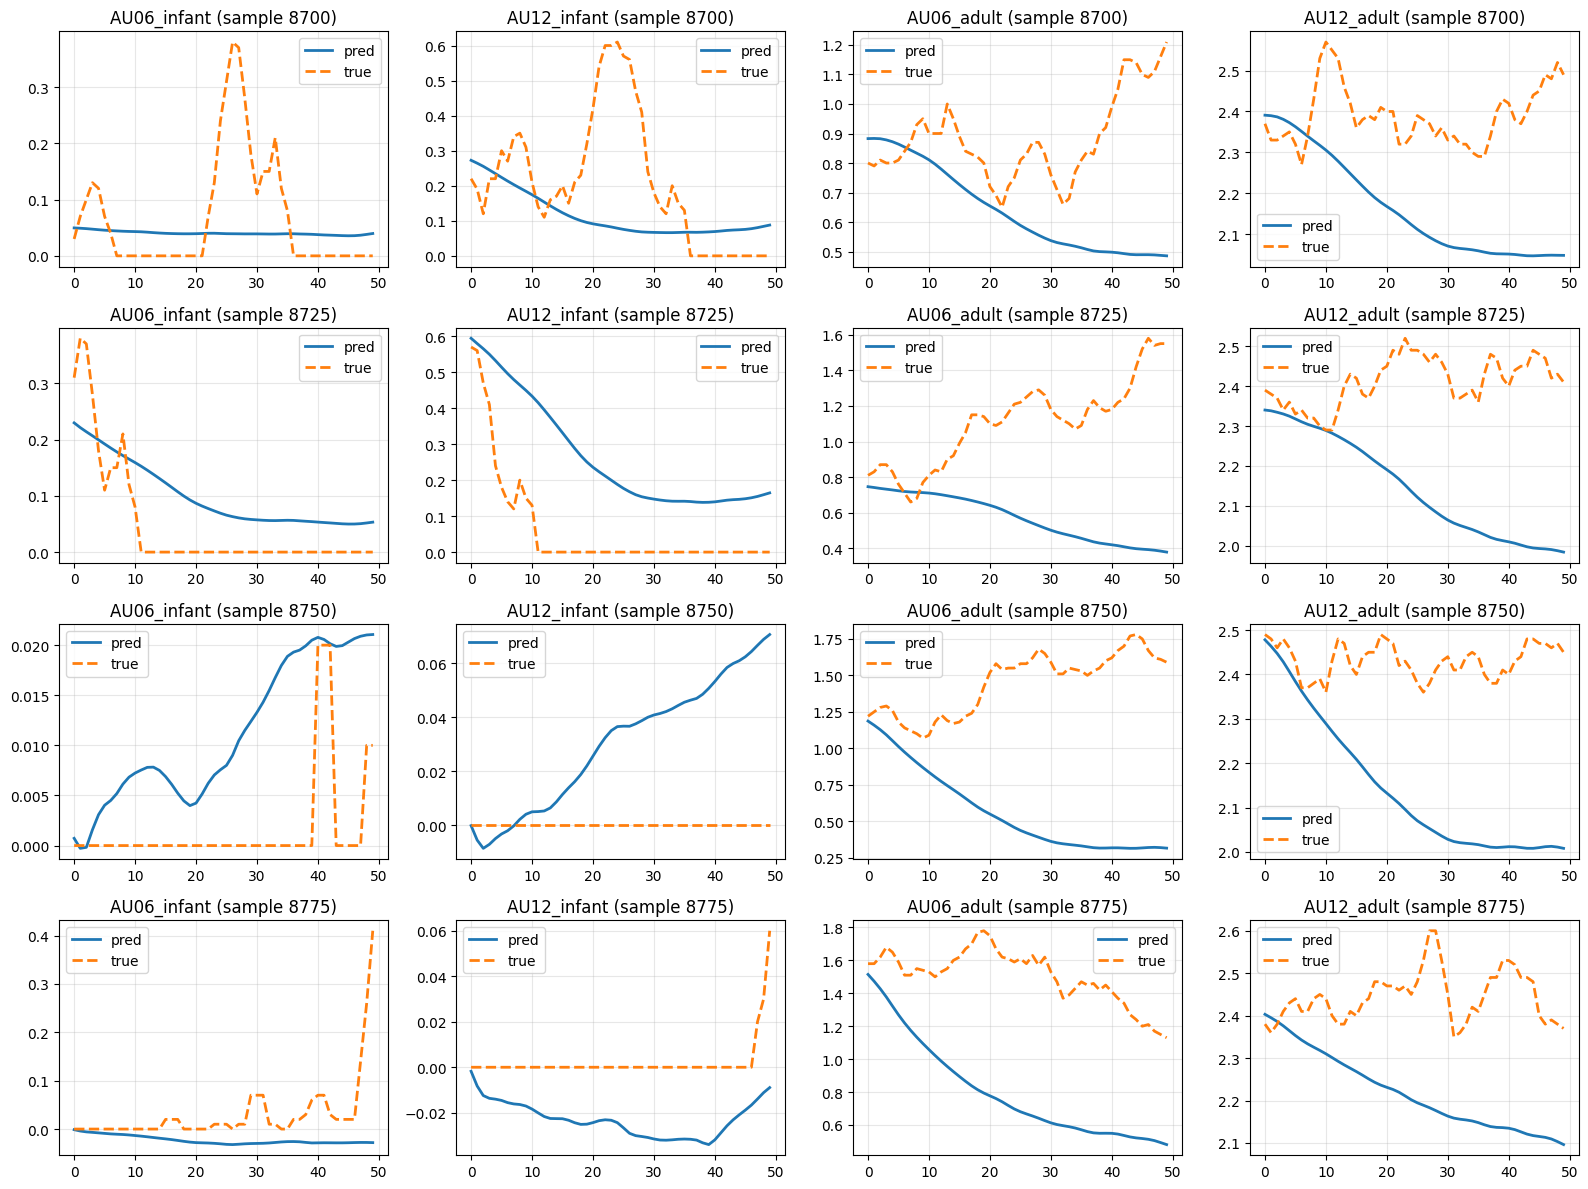

In [23]:
# Plot multiple test case predictions
from matplotlib import pyplot as plt
from models.maskedTimeSeriesTransformerWithHistory import MaskedTimeSeriesTransformerWithHistory as MaskedTimeSeriesTransformer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaskedTimeSeriesTransformer(d_model=32).to(device)
model.load_state_dict(torch.load('/net/tscratch/people/plgfimpro/korelacje/model_with_revin_fixed_context/masked_m1_in300_out50_lr1e-3-0.pt')['model_state_dict'])
num_examples = 4
start = 8700
fig, axes = plt.subplots(num_examples, 4, figsize=(16, 3 * num_examples))
labels = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']
test_idxs = [start, start+25, start+50, start+75]
model.eval()
with torch.no_grad():
    for example_idx in range(num_examples):
        rand_idx = test_idxs[example_idx]
        src_single, tgt_single = test_dataset[rand_idx]
        src_single = src_single.unsqueeze(0).to(device)
        tgt_single = tgt_single.unsqueeze(0).to(device)
        
        child_src = src_single[..., :2]
        mom_src = src_single[..., 2:]
        # Use autoregressive generation instead of passing zeros
        pred_single = model.forward_autoregressive(child_src, mom_src, 
                                    mask_child=False, mask_mom=False, tgt_len=tgt_single.size(1))
        print(pred_single.shape, tgt_single.shape)
        for feat_idx, label in enumerate(labels):
            ax = axes[example_idx, feat_idx]
            ax.plot(pred_single[0, :, feat_idx].cpu().numpy(), label='pred', linewidth=2)
            ax.plot(tgt_single[0, :, feat_idx].cpu().numpy(), label='true', linewidth=2, linestyle='--')
            ax.set_title(f"{label} (sample {rand_idx})")
            ax.legend()
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

MSE: [4.0745153e-06 1.4614813e-02 3.3346778e-03 4.2221174e-02]


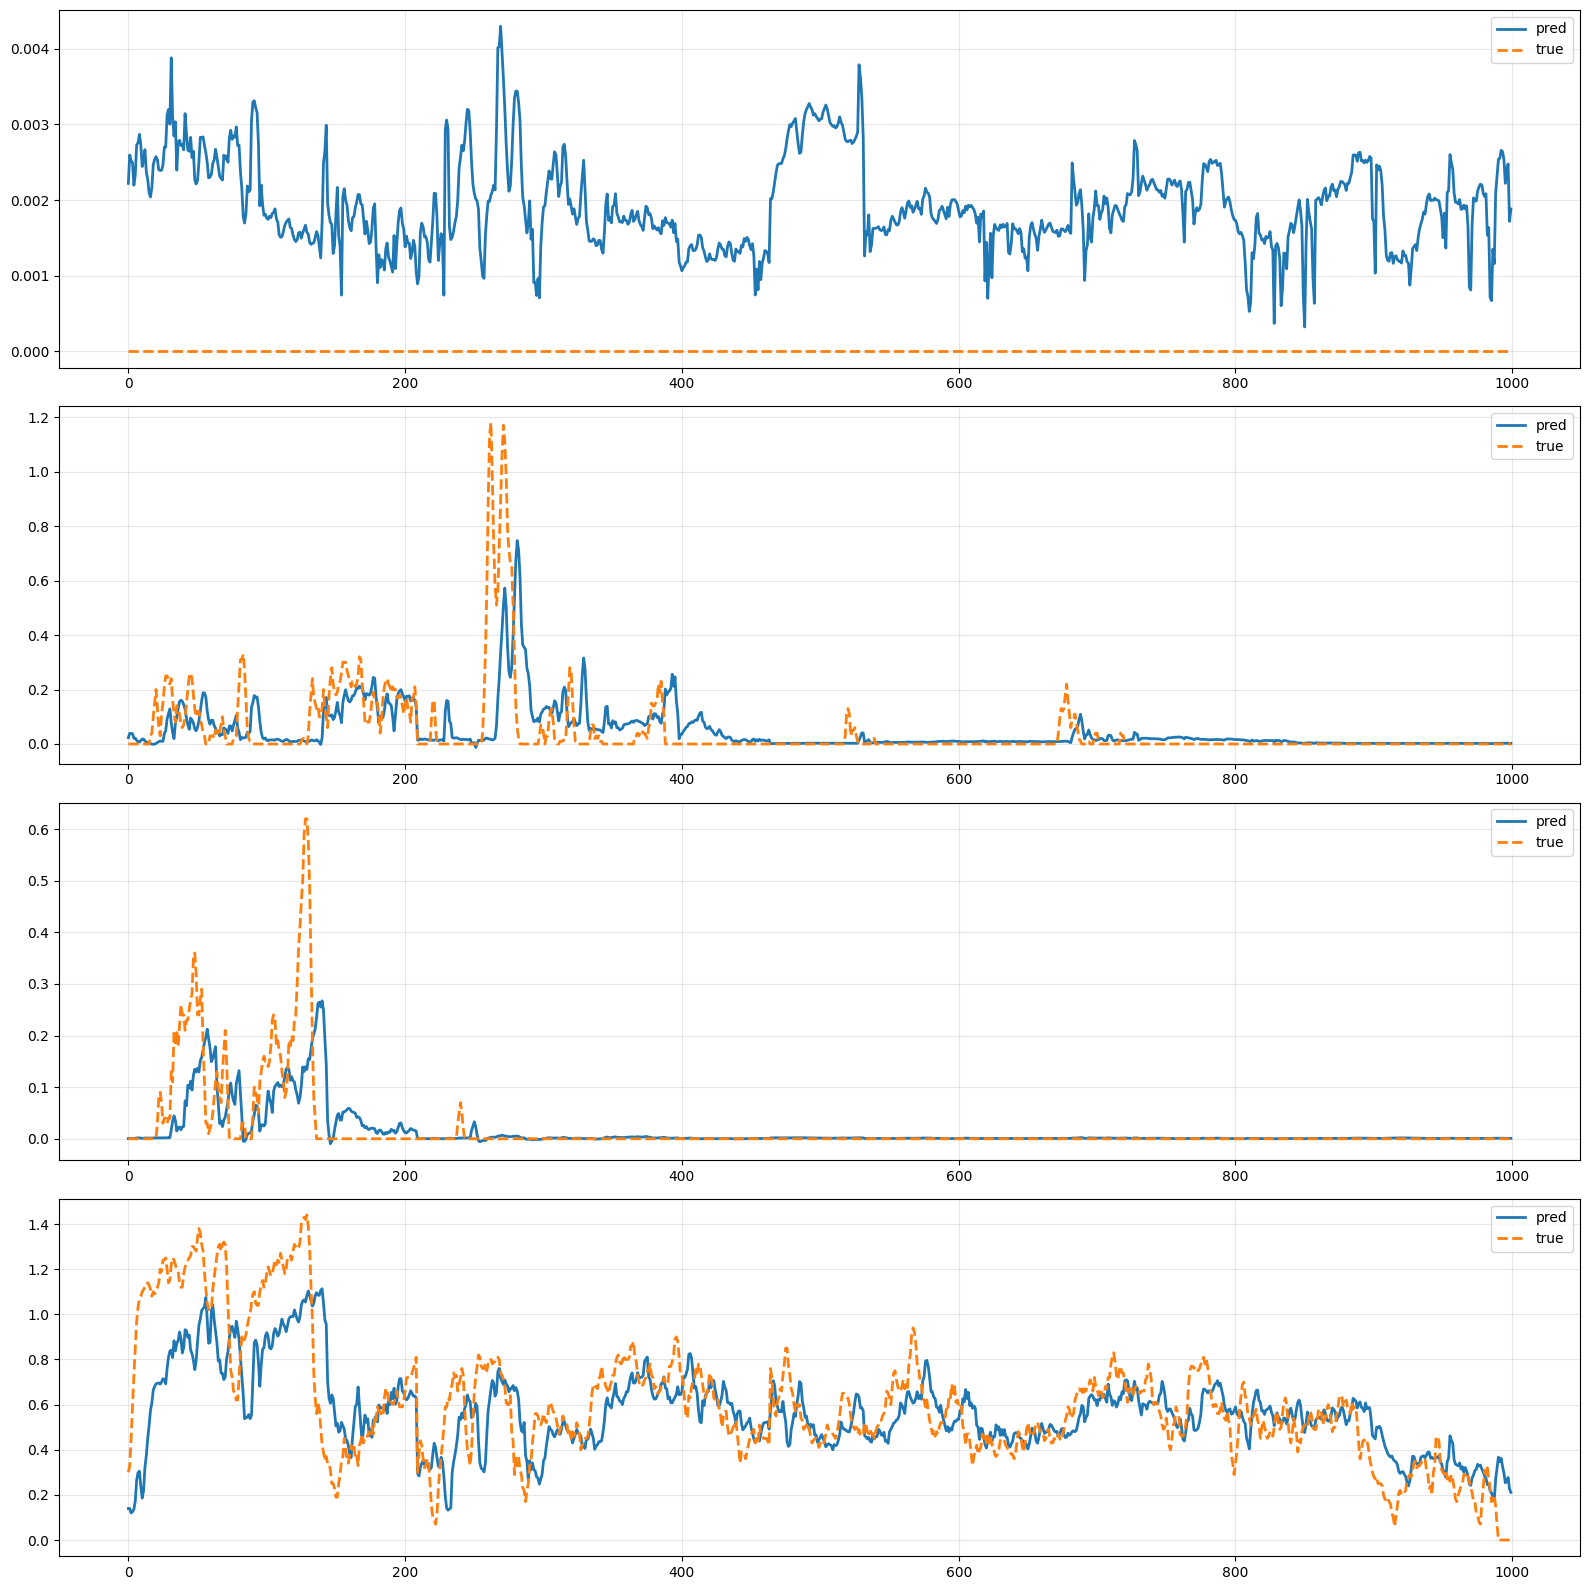

In [24]:
plot_long_segment(timestep=9, mask_mom=False, mask_child=False, dataset=train_dataset, model=model, device=device, start=2000)

MSE: [4.5682180e-05 1.7976590e-02 1.1564826e-03 2.5383871e-02]


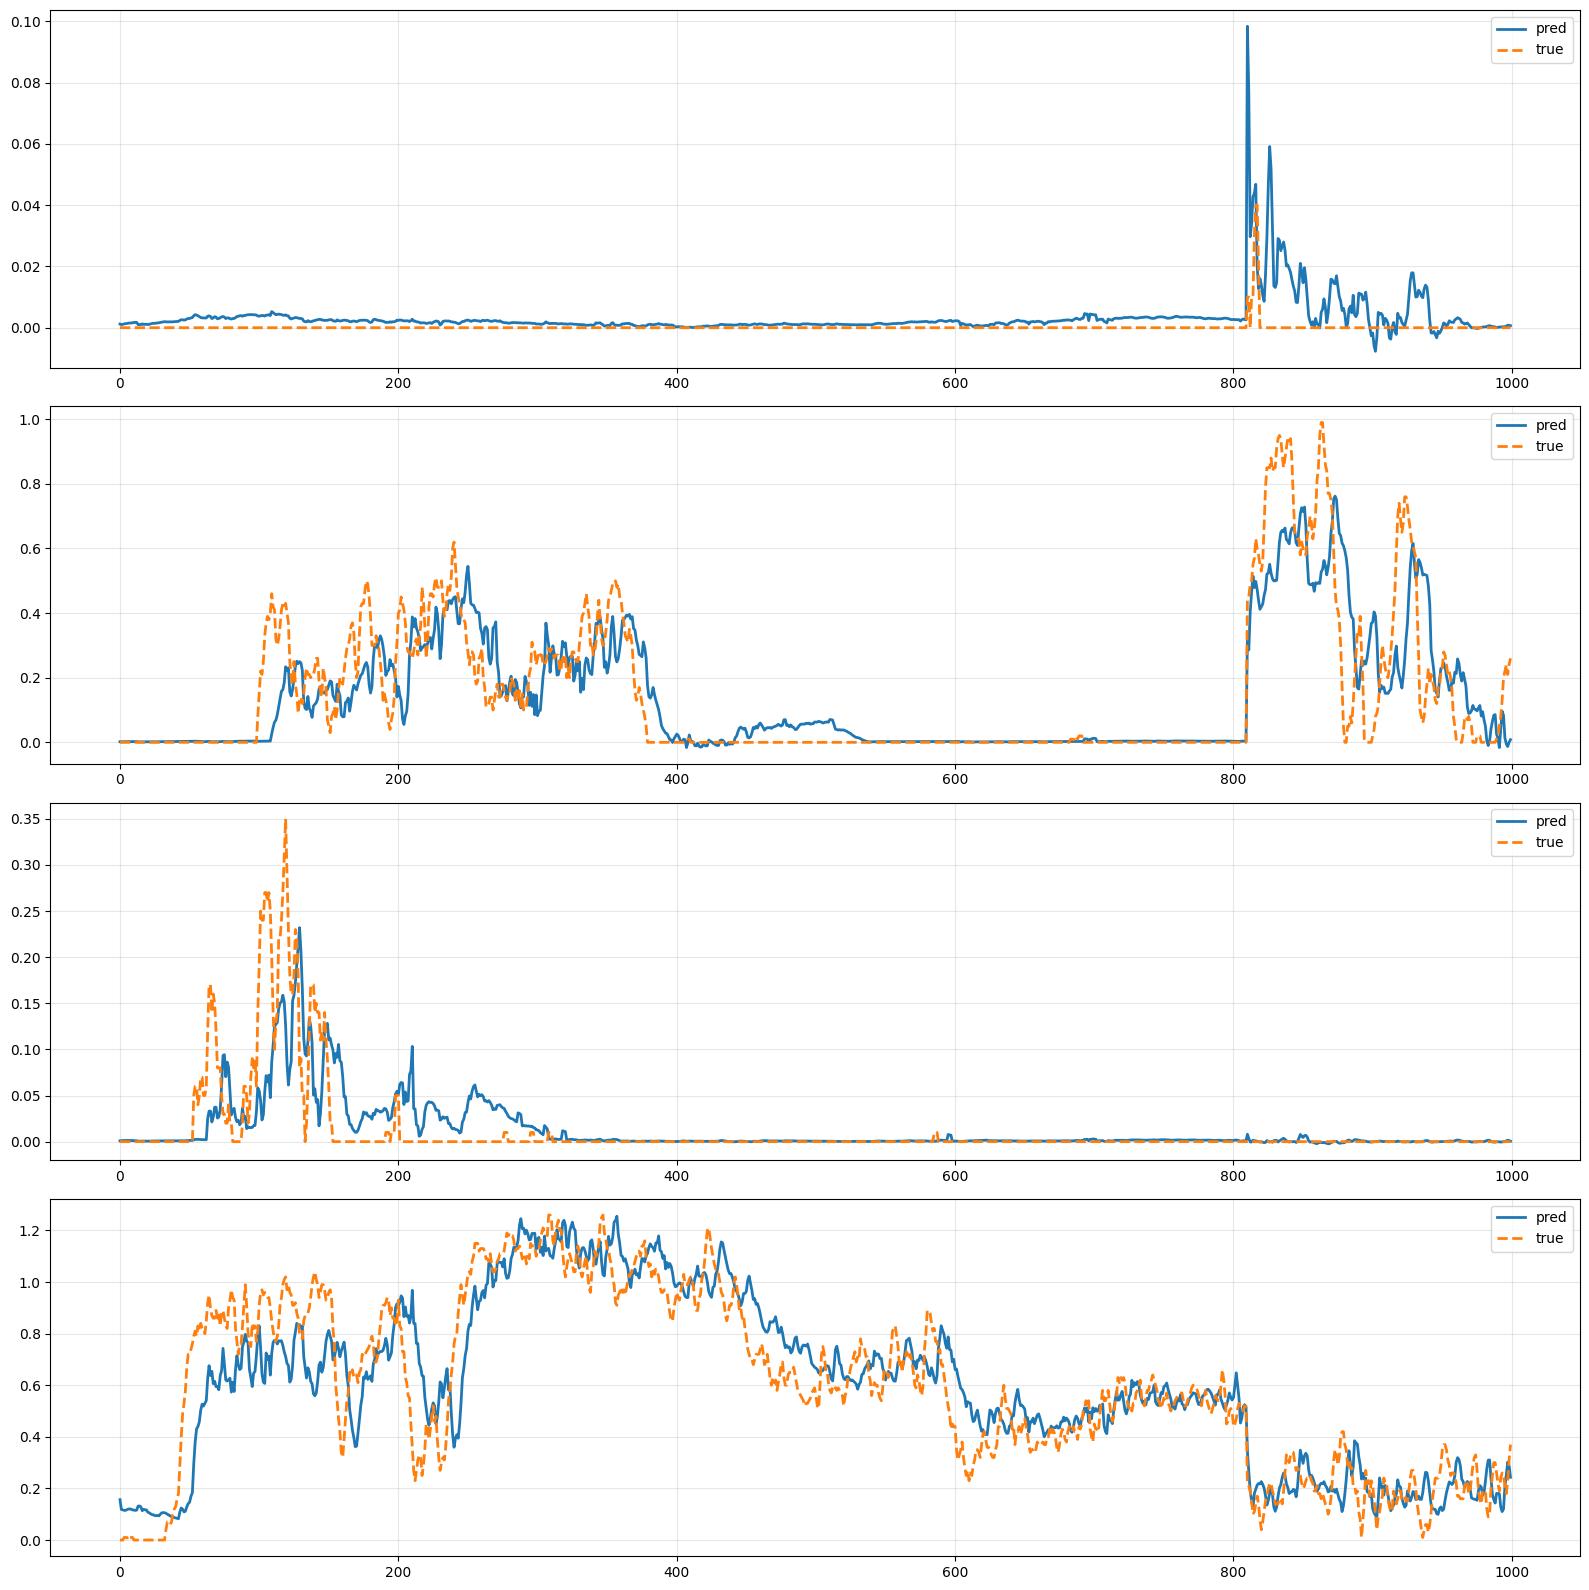

In [25]:
plot_long_segment(timestep=9, mask_mom=False, mask_child=False, dataset=train_dataset, model=model, device=device, start=3000)

MSE: [0.03937729 0.04435244 0.03398656 0.05130907]


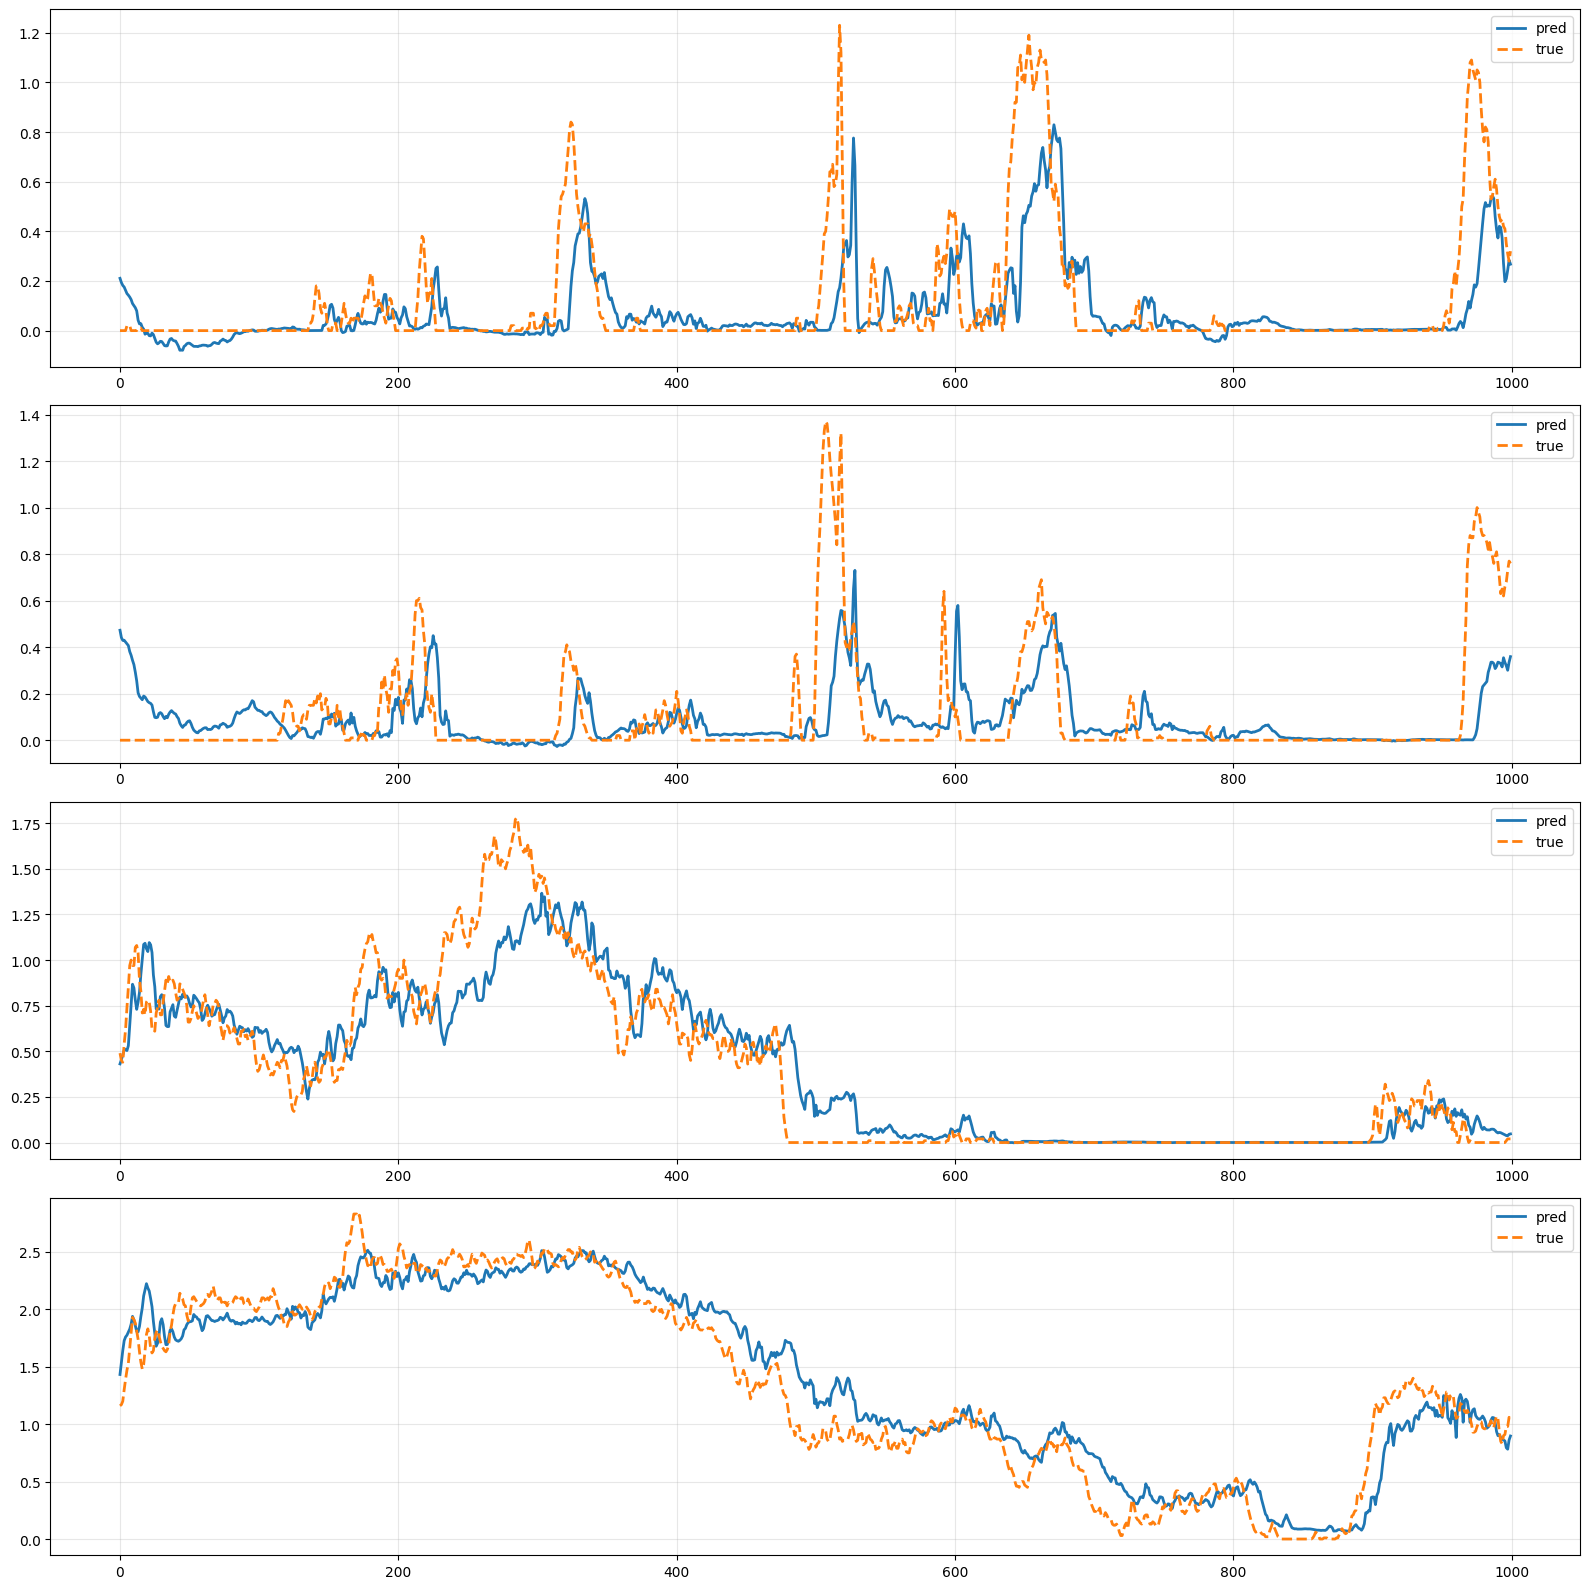

In [26]:
plot_long_segment(timestep=9, mask_mom=False, mask_child=False, dataset=test_dataset, model=model, device=device)

In [29]:
from pathlib import Path
import pandas as pd
import torch
from models.maskedTimeSeriesTransformerWithHistory import MaskedTimeSeriesTransformerWithHistory as MaskedTimeSeriesTransformer
import numpy as np
result_df = pd.DataFrame(columns=['model_name', 'mse_no_mask_mom_AU06_infant', 'mse_no_mask_mom_AU12_infant',
                             'mse_no_mask_mom_AU06_adult', 'mse_no_mask_mom_AU12_adult',
                             'mse_masked_mom_AU06_infant', 'mse_masked_mom_AU12_infant',
                             'mse_masked_mom_AU06_adult', 'mse_masked_mom_AU12_adult',
                             'mse_masked_child_AU06_infant', 'mse_masked_child_AU12_infant',
                             'mse_masked_child_AU06_adult', 'mse_masked_child_AU12_adult',
                            ])
for modelpath in list(Path('/net/tscratch/people/plgfimpro/korelacje/model_with_revin_fixed_context').glob('masked_m?_in300_out50_lr1e-3-1.pt')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MaskedTimeSeriesTransformer(d_model=32).to(device)
    model.load_state_dict(torch.load(modelpath)['model_state_dict'])
    not_masked = calculate_MSE(model, timestep=9, dataset=test_dataset)
    masked_mom = calculate_MSE(model, timestep=9, mask_mom=True, dataset=test_dataset)
    masked_child = calculate_MSE(model, timestep=9, mask_child=True, dataset=test_dataset)
    result_df.loc[len(result_df)] = np.concatenate(([modelpath.name], not_masked, masked_mom, masked_child))
    print(modelpath)

KeyboardInterrupt: 

In [ ]:
result_df.to_csv('transformer_with_history_results_months.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create visualization of MSE results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
features = ['AU06_infant', 'AU12_infant', 'AU06_adult', 'AU12_adult']

for idx, feature in enumerate(features):
    ax = axes[idx // 2, idx % 2]
    
    # Extract MSE values for this feature
    no_mask = result_df[f'mse_no_mask_mom_{feature}'].astype(float)
    masked_mom = result_df[f'mse_masked_mom_{feature}'].astype(float)
    masked_child = result_df[f'mse_masked_child_{feature}'].astype(float)
    
    x = np.arange(len(result_df))
    width = 0.25
    
    bars1 = ax.bar(x - width, no_mask, width, label='No Mask', alpha=0.8)
    #bars2 = ax.bar(x, masked_mom, width, label='Masked Mom', alpha=0.8)
    #bars3 = ax.bar(x + width, masked_child, width, label='Masked Child', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('MSE', fontsize=12)
    ax.set_title(f'MSE Comparison for {feature}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(result_df['model_name'], rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
for feature in features:
    print(f"\n{feature}:")
    print(f"  No Mask:      mean={result_df[f'mse_no_mask_mom_{feature}'].astype(float).mean():.6f}, std={result_df[f'mse_no_mask_mom_{feature}'].astype(float).std():.6f}")
    print(f"  Masked Mom:   mean={result_df[f'mse_masked_mom_{feature}'].astype(float).mean():.6f}, std={result_df[f'mse_masked_mom_{feature}'].astype(float).std():.6f}")
    print(f"  Masked Child: mean={result_df[f'mse_masked_child_{feature}'].astype(float).mean():.6f}, std={result_df[f'mse_masked_child_{feature}'].astype(float).std():.6f}")

In [16]:

datasets = {}
for context_size in [300, 200, 100, 50, 25, 10, 1]:
    datasets[context_size] = load_multiple_files(2, Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), context_size, 50)

In [17]:
datasets

{300: (tensor([[[0.0100, 0.4400, 0.0000, 0.3900],
           [0.0500, 0.4400, 0.0000, 0.4000],
           [0.0400, 0.2000, 0.0000, 0.3700],
           ...,
           [0.0000, 0.0000, 0.0000, 0.0500],
           [0.0000, 0.0000, 0.0000, 0.1100],
           [0.0000, 0.0000, 0.0000, 0.2000]],
  
          [[0.0500, 0.4400, 0.0000, 0.4000],
           [0.0400, 0.2000, 0.0000, 0.3700],
           [0.0400, 0.0000, 0.0000, 0.3800],
           ...,
           [0.0000, 0.0000, 0.0000, 0.1100],
           [0.0000, 0.0000, 0.0000, 0.2000],
           [0.0000, 0.0000, 0.0000, 0.2400]],
  
          [[0.0400, 0.2000, 0.0000, 0.3700],
           [0.0400, 0.0000, 0.0000, 0.3800],
           [0.0000, 0.0000, 0.0000, 0.4900],
           ...,
           [0.0000, 0.0000, 0.0000, 0.2000],
           [0.0000, 0.0000, 0.0000, 0.2400],
           [0.0000, 0.0000, 0.0000, 0.2800]],
  
          ...,
  
          [[0.0000, 0.5300, 0.0000, 1.2900],
           [0.0000, 0.6000, 0.0000, 1.2700],
           [0.000

In [18]:
for context_size, (X_train, Y_train, X_test, Y_test) in datasets.items():
    torch.save(
        {"X_train": X_train, "Y_train": Y_train, "X_test": X_test, "Y_test": Y_test},
        f"/net/tscratch/people/plgfimpro/korelacje/datasets/dataset_ctx{context_size}_out50.pt",
    )

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaskedTimeSeriesTransformer(d_model=32).to(device)
model.load_state_dict(torch.load('/net/tscratch/people/plgfimpro/korelacje/model_with_revin_fixed_context/masked_m1_in300_out50_lr1e-3-0.pt')['model_state_dict'])

result_df = pd.DataFrame(columns=['context_size', 'mse_no_mask_mom_AU06_infant', 'mse_no_mask_mom_AU12_infant',
                             'mse_no_mask_mom_AU06_adult', 'mse_no_mask_mom_AU12_adult',
                             'mse_masked_mom_AU06_infant', 'mse_masked_mom_AU12_infant',
                             'mse_masked_mom_AU06_adult', 'mse_masked_mom_AU12_adult',
                             'mse_masked_child_AU06_infant', 'mse_masked_child_AU12_infant',
                             'mse_masked_child_AU06_adult', 'mse_masked_child_AU12_adult',])
for context_size, (X_train, Y_train, X_test, Y_test) in datasets.items():
    train_dataset =  TimeSeriesDataset(X_train, Y_train)
    test_dataset = TimeSeriesDataset(X_test, Y_test)
    print(train_dataset, test_dataset)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    not_masked = calculate_MSE(model, timestep=9, dataset=test_dataset)
    masked_mom = [0,0,0,0] #calculate_MSE(model, timestep=9, mask_mom=True, dataset=test_dataset)
    masked_child =  [0,0,0,0] # calculate_MSE(model, timestep=9, mask_child=True, dataset=test_dataset)
    result_df.loc[len(result_df)] = np.concatenate(([context_size], not_masked, masked_mom, masked_child))

<utils.TimeSeriesDataset object at 0x148db571ecd0> <utils.TimeSeriesDataset object at 0x148db5631990>
<utils.TimeSeriesDataset object at 0x148dab4bc110> <utils.TimeSeriesDataset object at 0x148db5652110>
<utils.TimeSeriesDataset object at 0x148dab50ec90> <utils.TimeSeriesDataset object at 0x148dae40e490>
<utils.TimeSeriesDataset object at 0x148dab49dad0> <utils.TimeSeriesDataset object at 0x148d8d243950>
<utils.TimeSeriesDataset object at 0x148d8d0abbd0> <utils.TimeSeriesDataset object at 0x148dab4bc110>
<utils.TimeSeriesDataset object at 0x148dab49dad0> <utils.TimeSeriesDataset object at 0x148d8d040210>
<utils.TimeSeriesDataset object at 0x148daea7bbd0> <utils.TimeSeriesDataset object at 0x148dab4bc110>


<Axes: xlabel='context_size'>

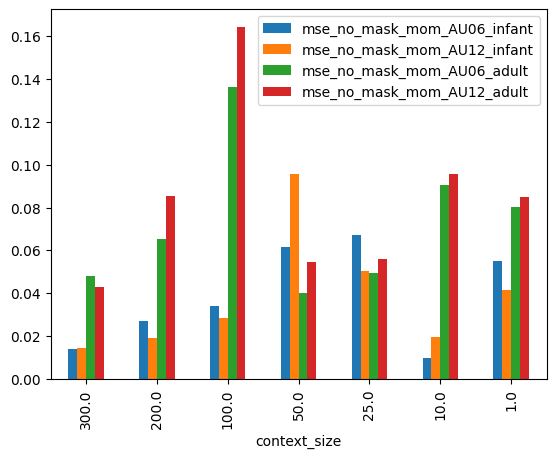

In [36]:
result_df.plot(x= 'context_size', y = ['mse_no_mask_mom_AU06_infant', 'mse_no_mask_mom_AU12_infant',
                             'mse_no_mask_mom_AU06_adult', 'mse_no_mask_mom_AU12_adult'], kind='bar')

<Axes: xlabel='context_size'>

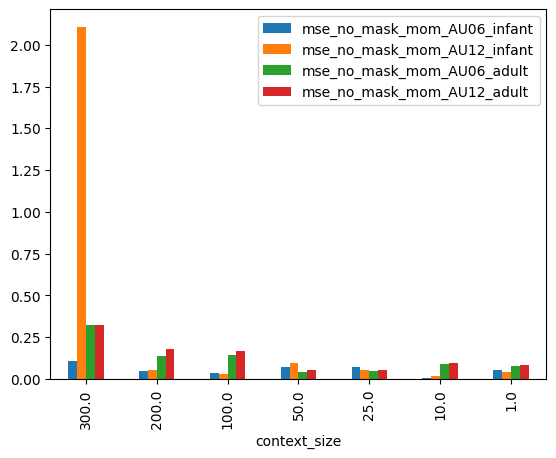

In [ ]:
result_df.plot(x= 'context_size', y = ['mse_no_mask_mom_AU06_infant', 'mse_no_mask_mom_AU12_infant',
                             'mse_no_mask_mom_AU06_adult', 'mse_no_mask_mom_AU12_adult'], kind='bar')